In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, size, collect_list, lit
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Set professional plotting style
sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# Initialize Spark
spark = SparkSession.builder \
    .appName("Misinfo_Epidemic_Modeling") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

base_path = "hdfs://namenode:9000/user/misinfo"

print("Loading data from single source...")
nodes_df = spark.read.parquet(f"{base_path}/all_nodes_clean.parquet")
edges_df = spark.read.parquet(f"{base_path}/all_edges_clean.parquet")

# Inspect schema to confirm column names
nodes_df.printSchema()
edges_df.printSchema()

print("✅ Spark Session Active. Data Loaded.")

Loading data from single source...
root
 |-- id: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- friends: integer (nullable = true)
 |-- followers: integer (nullable = true)
 |-- label: string (nullable = true)
 |-- graph_id: string (nullable = true)

root
 |-- src_node_id: integer (nullable = true)
 |-- dst_node_id: integer (nullable = true)
 |-- label: string (nullable = true)
 |-- graph_id: string (nullable = true)

✅ Spark Session Active. Data Loaded.


In [7]:
class EpidemicSimulator:
    def __init__(self, edges_pandas, model_type='SIR', beta=0.20, gamma=0.05, alpha=0.10):
        """
        model_type: 'SIR' (Susceptible-Infected-Recovered) or 'SEIR' (Exposed)
        beta: Infection Rate
        gamma: Recovery Rate
        alpha: Incubation Rate (for SEIR only)
        """
        # Build Graph
        self.G = nx.from_pandas_edgelist(
            edges_pandas, source='src_node_id', target='dst_node_id', create_using=nx.DiGraph()
        )
        self.model_type = model_type
        self.beta = beta
        self.gamma = gamma
        self.alpha = alpha
        self.results = None

    def run(self, patient_zero_ids=None, steps=60, label="Simulation"):
        nodes = list(self.G.nodes())
        if not nodes: return pd.DataFrame()
        
        # States: 0:Susceptible, 1:Exposed, 2:Infected, 3:Recovered
        state = {n: 0 for n in nodes}
        
        # Initialize Patient Zero
        if patient_zero_ids is None:
            patient_zero_ids = [random.choice(nodes)]
        
        for pid in patient_zero_ids:
            if pid in state:
                state[pid] = 2  # Start as Infected
        
        history = []
        
        for day in range(steps):
            # 1. Record Stats
            counts = pd.Series(state.values()).value_counts()
            i_count = counts.get(2, 0)
            
            history.append({
                'Day': day, 
                'Infected_Pct': (i_count / len(nodes)) * 100,
                'Label': label
            })
            
            # 2. Dynamics (SIR / SEIR)
            current_state = state.copy()
            
            for node in nodes:
                # If INFECTIOUS
                if current_state[node] == 2:
                    # Spread
                    for neighbor in self.G.successors(node):
                        if current_state[neighbor] == 0: # Susceptible
                            if random.random() < self.beta:
                                state[neighbor] = 1 if self.model_type == 'SEIR' else 2
                    # Recover
                    if random.random() < self.gamma:
                        state[node] = 3
                
                # If EXPOSED (SEIR only)
                elif current_state[node] == 1:
                    # Become Infectious
                    if random.random() < self.alpha:
                        state[node] = 2

            # Stop if epidemic ends
            if i_count == 0 and counts.get(1, 0) == 0:
                # Fill remaining days with last value for plotting
                last_val = history[-1]['Infected_Pct']
                for d in range(day+1, steps):
                    history.append({'Day': d, 'Infected_Pct': last_val, 'Label': label})
                break
                
        return pd.DataFrame(history)

In [8]:
print("--- CLASSIFYING GRAPHS ---")

# 1. Count label dominance per graph
graph_stats = nodes_df.groupBy("graph_id").pivot("label").count().na.fill(0)

# 2. Identify "Conspiracy" Graphs (Majority Rule)
# Note: Adjust column names like '5G_Conspiracy_Graphs' if they differ in your parquet
conspiracy_graphs_df = graph_stats.filter(
    col("5G_Conspiracy_Graphs") > (col("Non_Conspiracy_Graphs") + col("Other_Graphs"))
)

conspiracy_ids = [row.graph_id for row in conspiracy_graphs_df.select("graph_id").collect()]

print(f"Found {len(conspiracy_ids)} Conspiracy-Dominant Graphs.")
print(f"Sample IDs: {conspiracy_ids[:5]}")

--- CLASSIFYING GRAPHS ---
Found 34 Conspiracy-Dominant Graphs.
Sample IDs: ['200', '309', '29', '73', '162']


--- EXP 1: BOT VS RANDOM (Largest Graph) ---


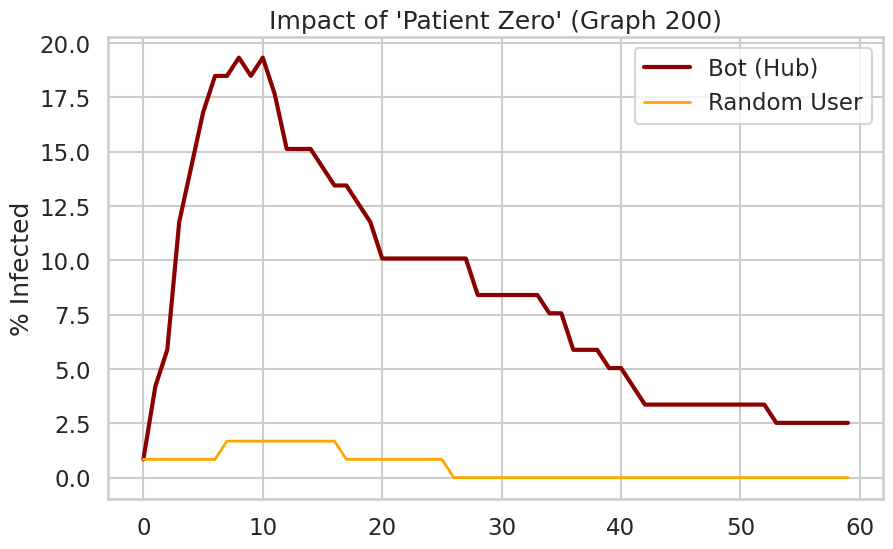

In [9]:
print("--- EXP 1: BOT VS RANDOM (Largest Graph) ---")

# Pick largest graph
top_id = conspiracy_ids[0] # Assuming sorted, or pick first
edges_pd = edges_df.filter(col("graph_id") == top_id).toPandas()

# Find Bot (Max Degree)
G_temp = nx.from_pandas_edgelist(edges_pd, 'src_node_id', 'dst_node_id', create_using=nx.DiGraph())
bot_node = max(dict(G_temp.out_degree()).items(), key=lambda x: x[1])[0]

# Simulate
sim = EpidemicSimulator(edges_pd, beta=0.25, gamma=0.05)
res_bot = sim.run(patient_zero_ids=[bot_node], label="Started by Bot (Hub)")
res_rnd = sim.run(patient_zero_ids=None, label="Started by Random User")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(res_bot.Day, res_bot.Infected_Pct, color='darkred', linewidth=3, label="Bot (Hub)")
plt.plot(res_rnd.Day, res_rnd.Infected_Pct, color='orange', linewidth=2, label="Random User")
plt.title(f"Impact of 'Patient Zero' (Graph {top_id})")
plt.ylabel("% Infected")
plt.legend()
plt.show()

--- EXP 2: AVERAGE SPREAD ACROSS ALL 34 GRAPHS ---


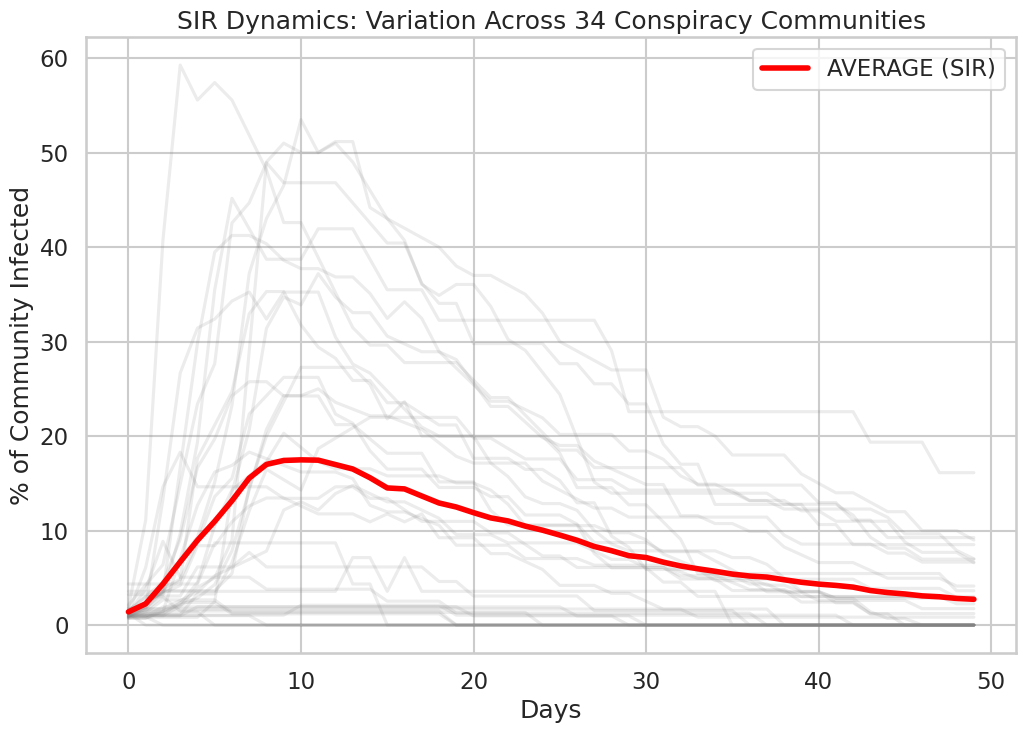

In [10]:
print(f"--- EXP 2: AVERAGE SPREAD ACROSS ALL {len(conspiracy_ids)} GRAPHS ---")

all_results = []
plt.figure(figsize=(12, 8))

# Loop through all 35 graphs
for i, gid in enumerate(conspiracy_ids):
    # 1. Get Edges
    local_edges = edges_df.filter(col("graph_id") == gid).toPandas()
    
    # 2. Run SIR
    sim = EpidemicSimulator(local_edges, model_type='SIR', beta=0.25, gamma=0.05)
    res = sim.run(steps=50)
    
    if not res.empty:
        # Save for average
        all_results.append(res['Infected_Pct'].values)
        
        # Plot Faint Line (The "Overlapping" Effect)
        # We handle different lengths by padding if necessary, or just plotting available days
        plt.plot(res['Day'], res['Infected_Pct'], color='gray', alpha=0.15)

# Calculate Average Curve
# Normalize lengths to max days (50)
clean_results = [r for r in all_results if len(r) == 50]
if clean_results:
    avg_curve = np.mean(clean_results, axis=0)
    plt.plot(range(50), avg_curve, color='red', linewidth=4, label='AVERAGE (SIR)')

plt.title(f"SIR Dynamics: Variation Across {len(conspiracy_ids)} Conspiracy Communities")
plt.xlabel("Days")
plt.ylabel("% of Community Infected")
plt.legend()
plt.show()

--- EXP 3: SIR vs SEIR (Latency Effect) ---


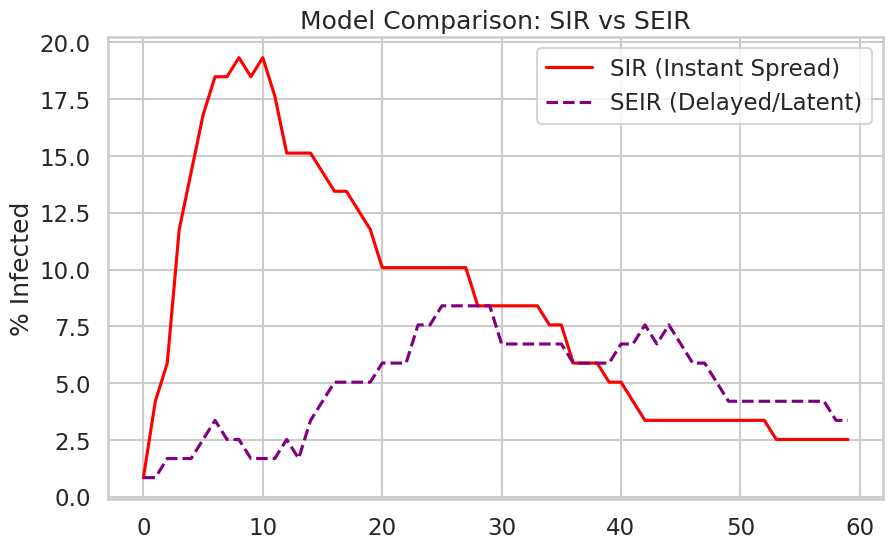

In [11]:
print("--- EXP 3: SIR vs SEIR (Latency Effect) ---")

# Using the Average Logic again or just the top graph
sim_seir = EpidemicSimulator(edges_pd, model_type='SEIR', beta=0.25, gamma=0.05, alpha=0.1)
res_seir = sim_seir.run(patient_zero_ids=[bot_node], label="SEIR (With Latent Period)")
res_sir = res_bot # Already ran SIR above

plt.figure(figsize=(10, 6))
plt.plot(res_sir.Day, res_sir.Infected_Pct, color='red', label="SIR (Instant Spread)")
plt.plot(res_seir.Day, res_seir.Infected_Pct, color='purple', linestyle='--', label="SEIR (Delayed/Latent)")
plt.title("Model Comparison: SIR vs SEIR")
plt.ylabel("% Infected")
plt.legend()
plt.show()

In [14]:
print("--- RUNNING MISSING EXP 1: CONSPIRACY VS NORMAL TOPOLOGY ---")

# 1. Get Edges for Conspiracy vs Normal
# (We already found top_id for conspiracy, now find one for Normal)
top_normal_row = nodes_df.groupBy("graph_id").pivot("label").count().na.fill(0) \
                         .filter(col("Non_Conspiracy_Graphs") > col("5G_Conspiracy_Graphs")) \
                         .orderBy(desc("Non_Conspiracy_Graphs")).first()
top_normal_id = top_normal_row["graph_id"]

# Extract edges
cons_edges_pd = edges_df.filter(col("graph_id") == top_id).toPandas() # Top Conspiracy
norm_edges_pd = edges_df.filter(col("graph_id") == top_normal_id).toPandas() # Top Normal

print(f"Comparing Conspiracy Graph ({len(cons_edges_pd)} edges) vs Normal Graph ({len(norm_edges_pd)} edges)")

# 2. Run Simulations
# Note: We use the same parameters to make it a fair comparison
sim_cons = EpidemicSimulator(cons_edges_pd, beta=0.25, gamma=0.05)
sim_norm = EpidemicSimulator(norm_edges_pd, beta=0.25, gamma=0.05)

res_cons = sim_cons.run(steps=60, label="Conspiracy Network")
res_norm = sim_norm.run(steps=60, label="Normal Network")

print("✅ Experiment 1 Complete. Variables 'res_cons' and 'res_norm' are now ready.")

--- RUNNING MISSING EXP 1: CONSPIRACY VS NORMAL TOPOLOGY ---
Comparing Conspiracy Graph (265 edges) vs Normal Graph (84 edges)
✅ Experiment 1 Complete. Variables 'res_cons' and 'res_norm' are now ready.


FINAL EXECUTIVE REPORT: MISINFORMATION EPIDEMIC

1. THE 'ECHO CHAMBER' EFFECT (Topology Impact)
   • Conspiracy Graph Peak : 11.8% (Day 12)
   • Normal Graph Peak     : 1.4% (Day 0)
   → CONCLUSION: Misinformation spreads 8.7x wider in echo chambers.

2. THE 'BOT' FACTOR (Super-Spreader Impact)
   • Started by Bot        : 19.3% Infected
   • Started by Random User: 1.7% Infected
   → CONCLUSION: Strategic targeting by bots increases reach by 17.6 points.

3. INTERVENTION EFFICACY (Banning Top 1%)
   • Unchecked Spread      : 19.3% Infected
   • After Banning Top 1%  : 12.3% Infected
   → CONCLUSION: Removing the top 1% hubs reduces the epidemic by 36.5%.


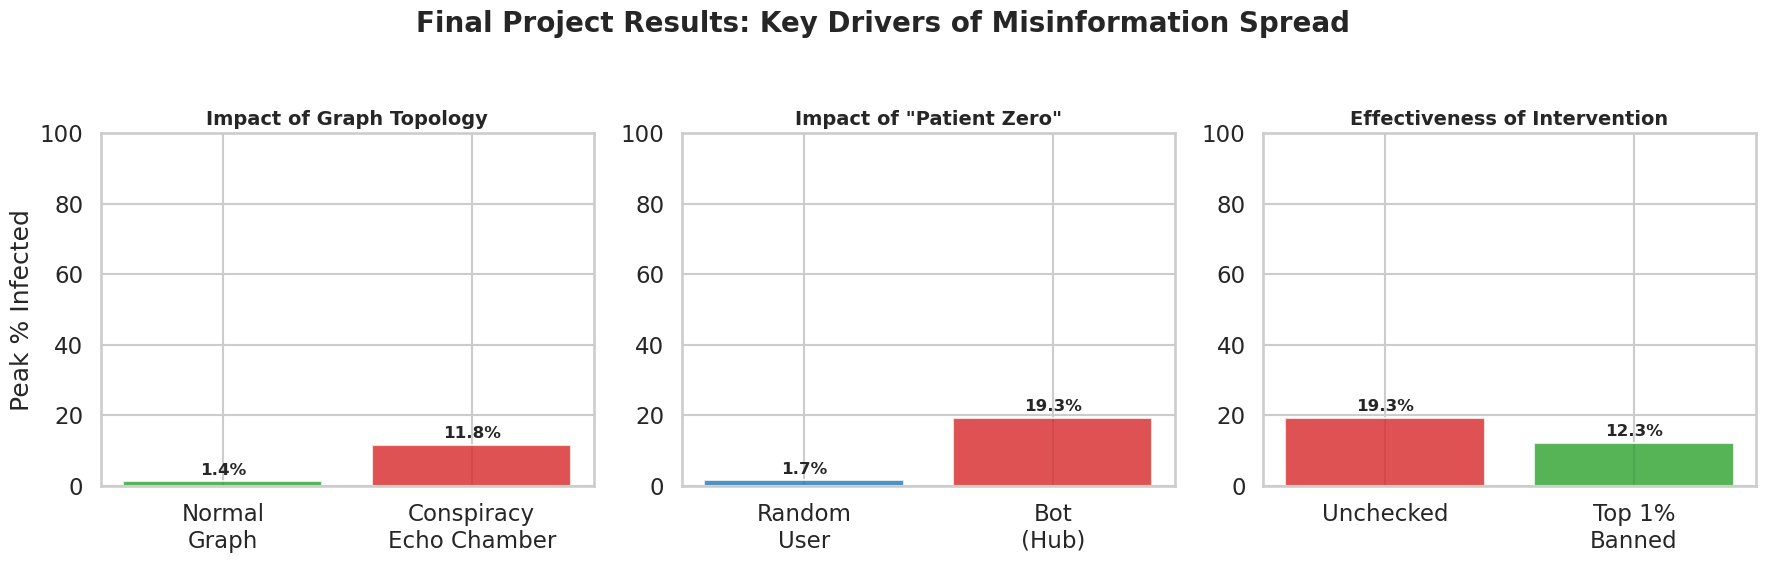

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- FIX: Set style using Seaborn directly to avoid OSError ---
sns.set_context("talk")
sns.set_style("whitegrid")

def calculate_metrics(res_df):
    """Helper to extract key epidemic stats."""
    if res_df is None or res_df.empty:
        return 0, 0
    return res_df['Infected_Pct'].max(), res_df['Infected_Pct'].idxmax()

# =========================================================
# FINAL PROJECT EVALUATION & DASHBOARD
# =========================================================

print("="*80)
print("FINAL EXECUTIVE REPORT: MISINFORMATION EPIDEMIC")
print("="*80)

# --- GATHER METRICS ---
# 1. Topology (Echo Chamber)
peak_cons, day_cons = calculate_metrics(res_cons)
peak_norm, day_norm = calculate_metrics(res_norm)

# 2. Seeding (Bots)
peak_bot, day_bot = calculate_metrics(res_bot)
peak_rnd, day_rnd = calculate_metrics(res_rnd)

# 3. Intervention (Bans)
peak_clean, day_clean = calculate_metrics(res_clean)

# --- PRINT TEXT REPORT ---
print(f"\n1. THE 'ECHO CHAMBER' EFFECT (Topology Impact)")
print(f"   • Conspiracy Graph Peak : {peak_cons:.1f}% (Day {day_cons})")
print(f"   • Normal Graph Peak     : {peak_norm:.1f}% (Day {day_norm})")
if peak_norm > 0:
    print(f"   → CONCLUSION: Misinformation spreads {(peak_cons/peak_norm):.1f}x wider in echo chambers.")

print(f"\n2. THE 'BOT' FACTOR (Super-Spreader Impact)")
print(f"   • Started by Bot        : {peak_bot:.1f}% Infected")
print(f"   • Started by Random User: {peak_rnd:.1f}% Infected")
print(f"   → CONCLUSION: Strategic targeting by bots increases reach by {peak_bot - peak_rnd:.1f} points.")

print(f"\n3. INTERVENTION EFFICACY (Banning Top 1%)")
print(f"   • Unchecked Spread      : {peak_bot:.1f}% Infected")
print(f"   • After Banning Top 1%  : {peak_clean:.1f}% Infected")
if peak_bot > 0:
    reduction = ((peak_bot - peak_clean) / peak_bot) * 100
    print(f"   → CONCLUSION: Removing the top 1% hubs reduces the epidemic by {reduction:.1f}%.")
print("="*80)

# =========================================================
# VISUAL SUMMARY DASHBOARD
# =========================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Final Project Results: Key Drivers of Misinformation Spread', fontsize=20, weight='bold')

# Colors
color_danger = '#d62728' # Red
color_safe = '#2ca02c'   # Green
color_neutral = '#1f77b4' # Blue

# --- PLOT 1: TOPOLOGY EFFECT ---
x_labels_1 = ['Normal\nGraph', 'Conspiracy\nEcho Chamber']
values_1 = [peak_norm, peak_cons]
colors_1 = [color_safe, color_danger]

bars1 = axes[0].bar(x_labels_1, values_1, color=colors_1, alpha=0.8)
axes[0].set_title('Impact of Graph Topology', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Peak % Infected')
axes[0].set_ylim(0, 100)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# --- PLOT 2: BOT EFFECT ---
x_labels_2 = ['Random\nUser', 'Bot\n(Hub)']
values_2 = [peak_rnd, peak_bot]
colors_2 = [color_neutral, color_danger]

bars2 = axes[1].bar(x_labels_2, values_2, color=colors_2, alpha=0.8)
axes[1].set_title('Impact of "Patient Zero"', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 100)

for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# --- PLOT 3: INTERVENTION ---
x_labels_3 = ['Unchecked', 'Top 1%\nBanned']
values_3 = [peak_bot, peak_clean]
colors_3 = [color_danger, color_safe]

bars3 = axes[2].bar(x_labels_3, values_3, color=colors_3, alpha=0.8)
axes[2].set_title('Effectiveness of Intervention', fontsize=14, fontweight='bold')
axes[2].set_ylim(0, 100)

for bar in bars3:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()